# < 2. ResNet Ablation Study > 

## [목표]
- 직접 ResNet 구현하기
- 모델을 config에 따라서 변경 가능하도록 만들기
- 직접 실험해서 성능 비교하기

## [루브릭]
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?

## [Ablation study]
- 직역: 제거연구
- 딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시하는데 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교한다
- 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험이다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

---

## 1. ResNet  블록 구성하기
- 논문 : https://arxiv.org/pdf/1512.03385.pdf

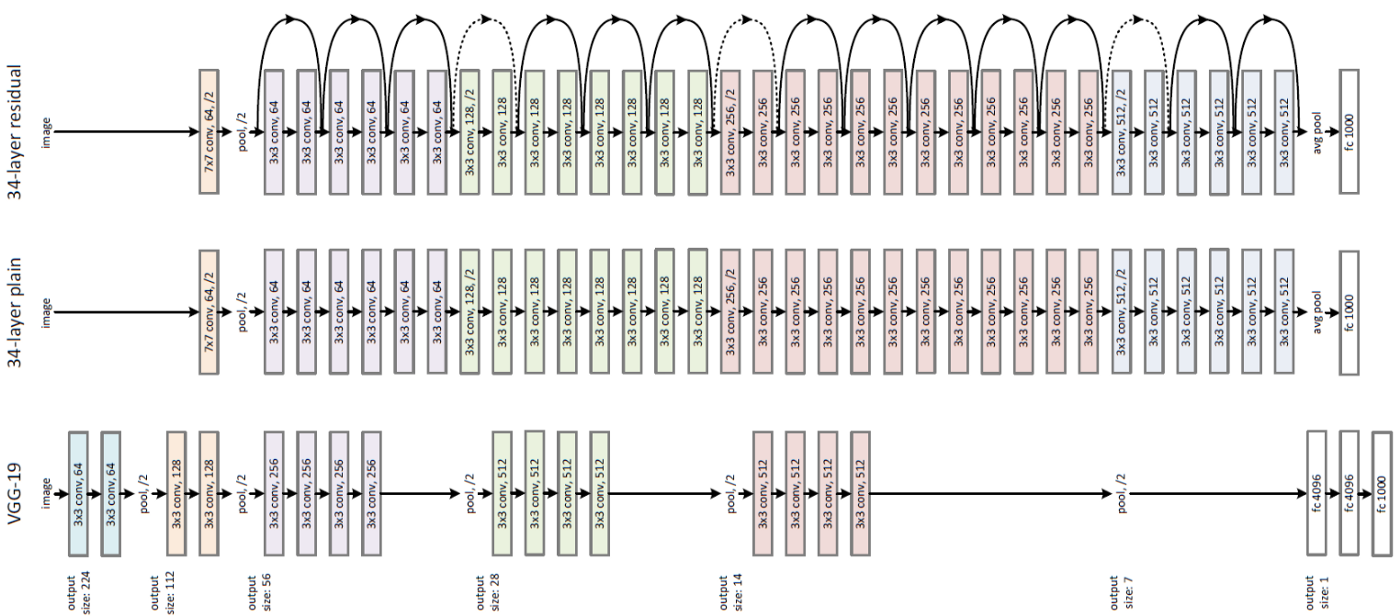
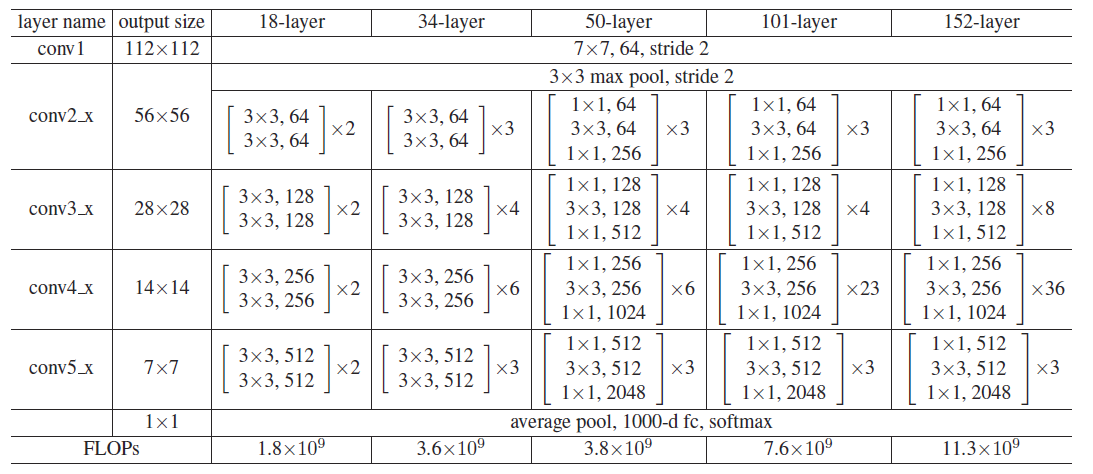

### conv_block
- conv2D 
- BatchNormalization
- Activation(relu)

In [2]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1,          
               activation='relu'):
    
    # convolutional layer    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)

    # Batch Normalization
    x = keras.layers.BatchNormalization()(x)

    # Relu Activation layer
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [3]:
def build_resnet_block_ornot( input_shape,
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=False, 
                       is_plain=False):
    x = input_shape

    # ResNet-34
    if not is_50 and not is_plain :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
            
    
    # ResNet-50
    elif is_50 and not is_plain:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # Plain-34
    elif not is_50 and is_plain :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
    
    # Plain-50
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1)) 
 
    return x   


In [4]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2, 
                 is_50=False, 
                 is_plain = False,
                 activation='sigmoid',
                 name = 'ResNet-34'):
    
    assert len(channel_list) == len(num_cnn_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # ResNet 34와 ResNet 50의 공통된 앞 부분
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual 블록을 생성
    # ResNet 34의 Residual 블록
    if not is_50 and not is_plain:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_block_ornot(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_plain=is_plain)    
    
    # ResNet 50의 Residual 블록
    elif is_50 and not is_plain:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_block_ornot(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_plain=is_plain)
            

    # Plain 34의 블록
    elif not is_50 and is_plain:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_block_ornot(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_plain=is_plain)            
    # Plain 50의 블록
    else:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_block_ornot(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_plain=is_plain)      

    
    x = keras.layers.AveragePooling2D(padding='same')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(num_classes,
                           activation=activation,
                           kernel_initializer='he_normal',
                           name='fc1000')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name = name)
    
    return model

### ResNet-34

In [5]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False, is_plain=False)
resnet_34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

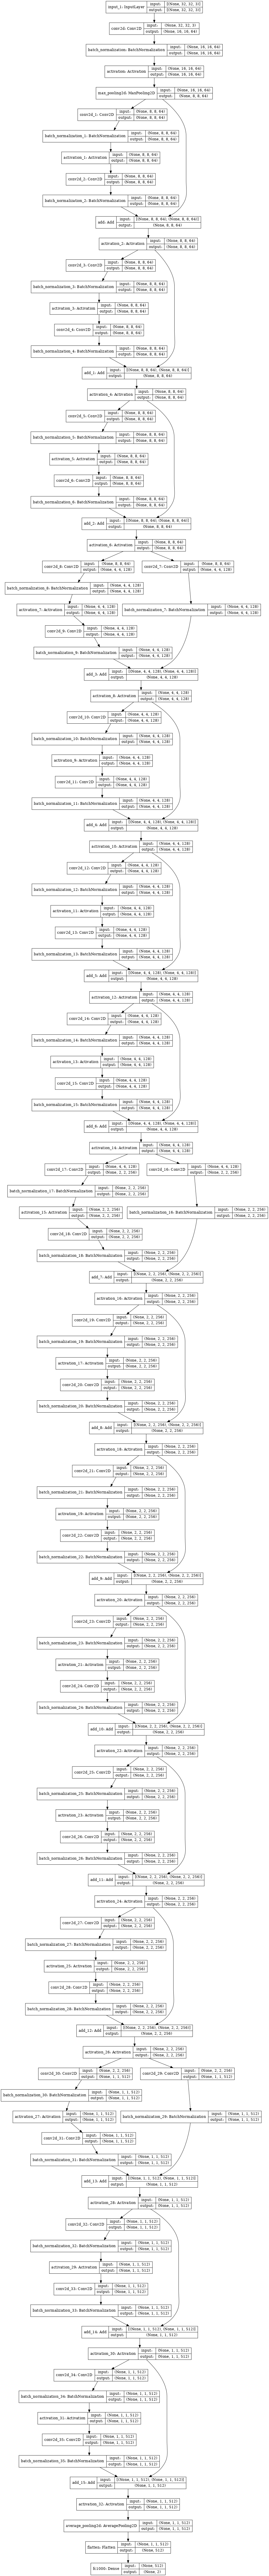

In [6]:
tf.keras.utils.plot_model(resnet_34, show_shapes=True, dpi=64)

### ResNet-50

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True, is_plain=False, name='ResNet-50')
resnet_50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

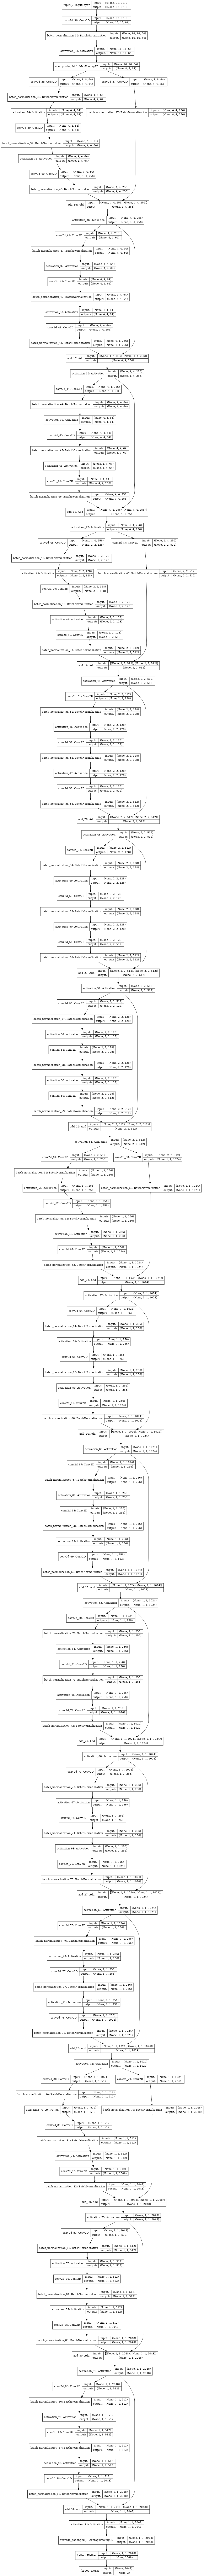

In [8]:
tf.keras.utils.plot_model(resnet_50, show_shapes=True, dpi=64)

---

## 2. plain network

### Plain-34

In [9]:
plain_34 = build_resnet(input_shape=(32, 32,3), is_50=False, is_plain=True, name='Plain-34')
plain_34.summary()

Model: "Plain-34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 8, 8, 64)          256

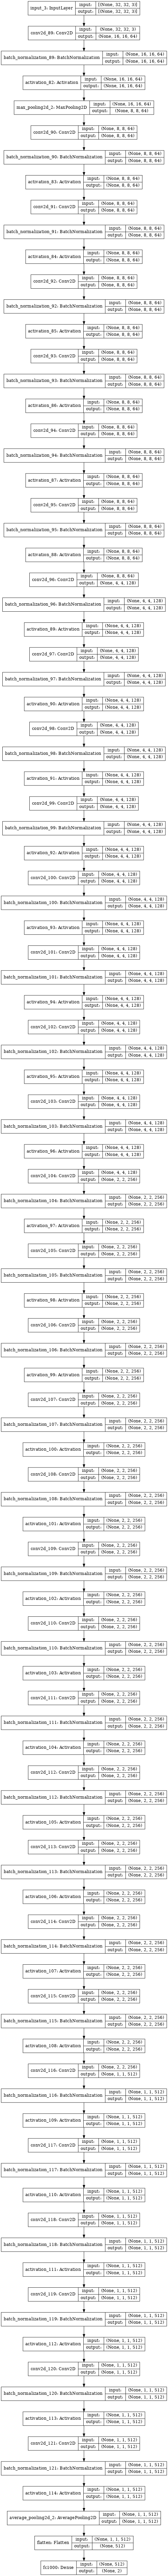

In [10]:
tf.keras.utils.plot_model(plain_34, show_shapes=True, dpi=64)

### Plain-50

In [11]:
plain_50 = build_resnet(input_shape=(32, 32,3), is_50=True, is_plain=True, name='Plain-50')
plain_50.summary()

Model: "Plain-50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_115 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 8, 8, 64)          256

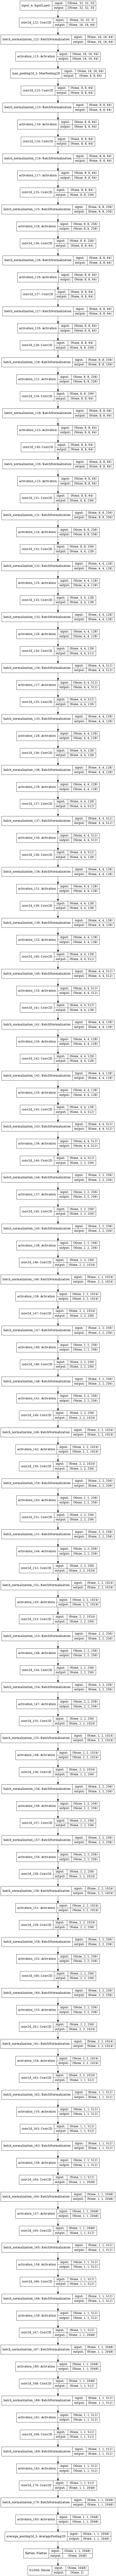

In [12]:
tf.keras.utils.plot_model(plain_50, show_shapes=True, dpi=64)

---

## 3. cats_vs_dogs dataset

In [13]:
# dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [14]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
# 데이터의 개수도 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [16]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    # image = image.reshape(1,240,240,3)
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
ds_info.features["label"].num_classes

2

In [18]:
ds_info.features["label"].names

['cat', 'dog']

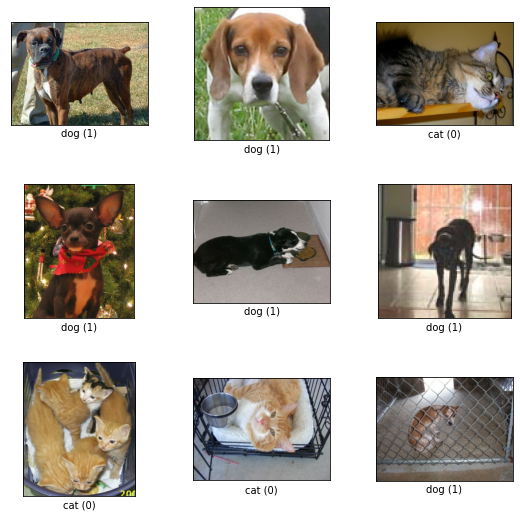

In [19]:
fig = tfds.show_examples(ds_train, ds_info)

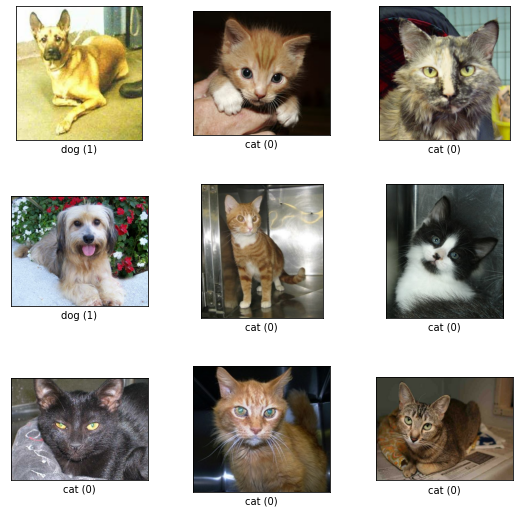

In [20]:
fig = tfds.show_examples(ds_test, ds_info)

---

## 4. 모델 훈련

In [21]:
BATCH_SIZE = 32
EPOCH = 10

In [22]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### ResNet34

In [23]:
# ResNet34
resnet_34 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=False, is_plain=False)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 1:34 - loss: 2.6085 - accuracy: 0.4944

 39/581 [=>............................] - ETA: 1:32 - loss: 2.5694 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:20 - loss: 2.5143 - accuracy: 0.5246

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 45s - loss: 2.4642 - accuracy: 0.5668

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 43s - loss: 2.4622 - accuracy: 0.5684

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 41s - loss: 2.4626 - accuracy: 0.5691

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 37s - loss: 2.4588 - accuracy: 0.5720

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 36s - loss: 2.4569 - accuracy: 0.5736

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.4309 - accuracy: 0.5927

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.4312 - accuracy: 0.5927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 137s 205ms/step - loss: 2.4312 - accuracy: 0.5927 - val_loss: 2.4334 - val_accuracy: 0.6186
Epoch 2/10
 30/581 [>.............................] - ETA: 1:37 - loss: 2.3748 - accuracy: 0.6385

 39/581 [=>............................] - ETA: 1:36 - loss: 2.3866 - accuracy: 0.6338

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:23 - loss: 2.3832 - accuracy: 0.6335

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 47s - loss: 2.3739 - accuracy: 0.6411

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 45s - loss: 2.3713 - accuracy: 0.6416

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 42s - loss: 2.3692 - accuracy: 0.6429

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 38s - loss: 2.3678 - accuracy: 0.6438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 36s - loss: 2.3671 - accuracy: 0.6440

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 2.3496 - accuracy: 0.6556

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3492 - accuracy: 0.6557

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 2.3492 - accuracy: 0.6557 - val_loss: 2.3948 - val_accuracy: 0.6425
Epoch 3/10
 29/581 [>.............................] - ETA: 1:39 - loss: 2.2987 - accuracy: 0.6897

 41/581 [=>............................] - ETA: 1:37 - loss: 2.2973 - accuracy: 0.6890

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:24 - loss: 2.3242 - accuracy: 0.6736

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 46s - loss: 2.3178 - accuracy: 0.6765

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 44s - loss: 2.3157 - accuracy: 0.6778

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 42s - loss: 2.3153 - accuracy: 0.6790

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 37s - loss: 2.3098 - accuracy: 0.6822

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 36s - loss: 2.3086 - accuracy: 0.6829

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.3010 - accuracy: 0.6890

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3009 - accuracy: 0.6889

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 202ms/step - loss: 2.3009 - accuracy: 0.6889 - val_loss: 2.6219 - val_accuracy: 0.5861
Epoch 4/10
 30/581 [>.............................] - ETA: 1:38 - loss: 2.2833 - accuracy: 0.7177

 43/581 [=>............................] - ETA: 1:36 - loss: 2.2788 - accuracy: 0.7115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:24 - loss: 2.2874 - accuracy: 0.7024

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 46s - loss: 2.2668 - accuracy: 0.7146

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 44s - loss: 2.2690 - accuracy: 0.7132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 41s - loss: 2.2691 - accuracy: 0.7136

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 37s - loss: 2.2701 - accuracy: 0.7130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 35s - loss: 2.2701 - accuracy: 0.7130

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 2.2536 - accuracy: 0.7217

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2531 - accuracy: 0.7219

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 2.2531 - accuracy: 0.7219 - val_loss: 2.3637 - val_accuracy: 0.6761
Epoch 5/10
 35/581 [>.............................] - ETA: 1:37 - loss: 2.2149 - accuracy: 0.7527

 41/581 [=>............................] - ETA: 1:36 - loss: 2.2135 - accuracy: 0.7538

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:23 - loss: 2.2198 - accuracy: 0.7427

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 45s - loss: 2.2111 - accuracy: 0.7492

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 44s - loss: 2.2106 - accuracy: 0.7497

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 41s - loss: 2.2095 - accuracy: 0.7501

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 36s - loss: 2.2044 - accuracy: 0.7530

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 35s - loss: 2.2044 - accuracy: 0.7532

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1909 - accuracy: 0.7620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 2.1909 - accuracy: 0.7620 - val_loss: 2.2762 - val_accuracy: 0.7194
Epoch 6/10
  1/581 [..............................] - ETA: 1:41 - loss: 2.2086 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:37 - loss: 2.1712 - accuracy: 0.7684

 43/581 [=>............................] - ETA: 1:36 - loss: 2.1774 - accuracy: 0.7682

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:23 - loss: 2.1603 - accuracy: 0.7858

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 2.1474 - accuracy: 0.7876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 44s - loss: 2.1481 - accuracy: 0.7878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 41s - loss: 2.1486 - accuracy: 0.7876

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 36s - loss: 2.1485 - accuracy: 0.7866

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 35s - loss: 2.1472 - accuracy: 0.7875

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1339 - accuracy: 0.7950

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 2.1339 - accuracy: 0.7950 - val_loss: 2.2595 - val_accuracy: 0.7446
Epoch 7/10
  4/581 [..............................] - ETA: 1:43 - loss: 2.0713 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:38 - loss: 2.1259 - accuracy: 0.8068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:37 - loss: 2.1184 - accuracy: 0.8108

119/581 [=====>........................] - ETA: 1:23 - loss: 2.0988 - accuracy: 0.8133

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 2.0779 - accuracy: 0.8263

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 45s - loss: 2.0779 - accuracy: 0.8263

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 41s - loss: 2.0744 - accuracy: 0.8283

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 2.0729 - accuracy: 0.8288

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 35s - loss: 2.0730 - accuracy: 0.8285

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


575/581 [============================>.] - ETA: 1s - loss: 2.0638 - accuracy: 0.8328

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.0633 - accuracy: 0.8329

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 2.0633 - accuracy: 0.8329 - val_loss: 2.2546 - val_accuracy: 0.7526
Epoch 8/10
 35/581 [>.............................] - ETA: 1:37 - loss: 2.0242 - accuracy: 0.8661

 47/581 [=>............................] - ETA: 1:35 - loss: 2.0097 - accuracy: 0.8664

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:22 - loss: 2.0133 - accuracy: 0.8614

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 46s - loss: 2.0062 - accuracy: 0.8644

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 43s - loss: 2.0063 - accuracy: 0.8644

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 41s - loss: 2.0052 - accuracy: 0.8653

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 2.0030 - accuracy: 0.8664

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 35s - loss: 2.0030 - accuracy: 0.8664

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.9908 - accuracy: 0.8714

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.9908 - accuracy: 0.8714 - val_loss: 2.3048 - val_accuracy: 0.7452
Epoch 9/10
  7/581 [..............................] - ETA: 1:42 - loss: 1.9548 - accuracy: 0.8973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 20/581 [>.............................] - ETA: 1:40 - loss: 1.9934 - accuracy: 0.8594

 47/581 [=>............................] - ETA: 1:35 - loss: 1.9632 - accuracy: 0.8783

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:22 - loss: 1.9548 - accuracy: 0.8832

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 45s - loss: 1.9392 - accuracy: 0.8900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 43s - loss: 1.9400 - accuracy: 0.8905

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 41s - loss: 1.9400 - accuracy: 0.8910

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 1.9393 - accuracy: 0.8915

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 35s - loss: 1.9381 - accuracy: 0.8922

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.9241 - accuracy: 0.9011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.9241 - accuracy: 0.9011 - val_loss: 2.2649 - val_accuracy: 0.7630
Epoch 10/10
  7/581 [..............................] - ETA: 1:42 - loss: 1.9201 - accuracy: 0.9018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 21/581 [>.............................] - ETA: 1:39 - loss: 1.9122 - accuracy: 0.9048

 49/581 [=>............................] - ETA: 1:35 - loss: 1.8834 - accuracy: 0.9165

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:23 - loss: 1.8761 - accuracy: 0.9263

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 45s - loss: 1.8702 - accuracy: 0.9281

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 43s - loss: 1.8684 - accuracy: 0.9289

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 1.8667 - accuracy: 0.9297

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 1.8639 - accuracy: 0.9311

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 1.8636 - accuracy: 0.9312

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.8519 - accuracy: 0.9364

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.8519 - accuracy: 0.9364 - val_loss: 2.3205 - val_accuracy: 0.7758


### ResNet50

In [24]:
# ResNet50
resnet_50 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=True, is_plain=False)

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:07 - loss: 6.1104 - accuracy: 0.5185

 40/581 [=>............................] - ETA: 1:05 - loss: 6.1012 - accuracy: 0.5227

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 57s - loss: 6.0903 - accuracy: 0.5304

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 32s - loss: 6.0770 - accuracy: 0.5437

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 30s - loss: 6.0752 - accuracy: 0.5454

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 29s - loss: 6.0739 - accuracy: 0.5463

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 25s - loss: 6.0720 - accuracy: 0.5457

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 25s - loss: 6.0724 - accuracy: 0.5452

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 6.0687 - accuracy: 0.5478

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.0682 - accuracy: 0.5482

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 99s 144ms/step - loss: 6.0682 - accuracy: 0.5482 - val_loss: 6.0401 - val_accuracy: 0.5567
Epoch 2/10
 29/581 [>.............................] - ETA: 1:07 - loss: 6.0601 - accuracy: 0.5571

 38/581 [>.............................] - ETA: 1:06 - loss: 6.0575 - accuracy: 0.5551

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 56s - loss: 6.0584 - accuracy: 0.5511

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 32s - loss: 6.0428 - accuracy: 0.5625

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 31s - loss: 6.0433 - accuracy: 0.5624

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 29s - loss: 6.0446 - accuracy: 0.5620

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 26s - loss: 6.0447 - accuracy: 0.5614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 25s - loss: 6.0442 - accuracy: 0.5617

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.0411 - accuracy: 0.5633

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 83s 143ms/step - loss: 6.0411 - accuracy: 0.5633 - val_loss: 6.0435 - val_accuracy: 0.5565
Epoch 3/10
  2/581 [..............................] - ETA: 1:09 - loss: 6.0455 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:06 - loss: 6.0142 - accuracy: 0.5744

 39/581 [=>............................] - ETA: 1:05 - loss: 6.0091 - accuracy: 0.5809

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


106/581 [====>.........................] - ETA: 57s - loss: 6.0233 - accuracy: 0.5761

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 31s - loss: 6.0279 - accuracy: 0.5667

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 30s - loss: 6.0269 - accuracy: 0.5670

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 29s - loss: 6.0255 - accuracy: 0.5685

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 25s - loss: 6.0243 - accuracy: 0.5713

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 25s - loss: 6.0235 - accuracy: 0.5717

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.0227 - accuracy: 0.5750

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 6.0227 - accuracy: 0.5750 - val_loss: 6.0931 - val_accuracy: 0.5602
Epoch 4/10
  4/581 [..............................] - ETA: 1:09 - loss: 6.0247 - accuracy: 0.5703

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 12/581 [..............................] - ETA: 1:09 - loss: 6.0180 - accuracy: 0.5755

 44/581 [=>............................] - ETA: 1:05 - loss: 6.0106 - accuracy: 0.5824

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 56s - loss: 6.0108 - accuracy: 0.5879

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 31s - loss: 6.0074 - accuracy: 0.5840

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 30s - loss: 6.0092 - accuracy: 0.5843

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 28s - loss: 6.0073 - accuracy: 0.5860

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 25s - loss: 6.0082 - accuracy: 0.5849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 24s - loss: 6.0090 - accuracy: 0.5845

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.0021 - accuracy: 0.5878

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 6.0021 - accuracy: 0.5878 - val_loss: 6.0652 - val_accuracy: 0.5776
Epoch 5/10
  1/581 [..............................] - ETA: 1:08 - loss: 5.8682 - accuracy: 0.7188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:06 - loss: 6.0148 - accuracy: 0.5823

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:06 - loss: 6.0121 - accuracy: 0.5866

120/581 [=====>........................] - ETA: 56s - loss: 5.9831 - accuracy: 0.6047

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 31s - loss: 5.9886 - accuracy: 0.5992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 28s - loss: 5.9881 - accuracy: 0.5987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 25s - loss: 5.9888 - accuracy: 0.5990

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 5.9889 - accuracy: 0.5992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9847 - accuracy: 0.6048

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9847 - accuracy: 0.6048 - val_loss: 5.9726 - val_accuracy: 0.5955
Epoch 6/10
  3/581 [..............................] - ETA: 1:09 - loss: 6.0026 - accuracy: 0.5833

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/581 [>.............................] - ETA: 1:07 - loss: 5.9624 - accuracy: 0.6022

 39/581 [=>............................] - ETA: 1:06 - loss: 5.9701 - accuracy: 0.6018

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 56s - loss: 5.9793 - accuracy: 0.5974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 31s - loss: 5.9770 - accuracy: 0.6046

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 30s - loss: 5.9767 - accuracy: 0.6055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 28s - loss: 5.9765 - accuracy: 0.6065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 5.9750 - accuracy: 0.6075

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 24s - loss: 5.9740 - accuracy: 0.6079

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9708 - accuracy: 0.6088

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9708 - accuracy: 0.6088 - val_loss: 6.0076 - val_accuracy: 0.5985
Epoch 7/10
  4/581 [..............................] - ETA: 1:10 - loss: 5.8941 - accuracy: 0.7266

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/581 [>.............................] - ETA: 1:07 - loss: 5.9770 - accuracy: 0.6058

 42/581 [=>............................] - ETA: 1:05 - loss: 5.9650 - accuracy: 0.6257

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 56s - loss: 5.9622 - accuracy: 0.6216

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 31s - loss: 5.9658 - accuracy: 0.6122

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 30s - loss: 5.9637 - accuracy: 0.6134

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 28s - loss: 5.9628 - accuracy: 0.6130

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 24s - loss: 5.9630 - accuracy: 0.6124

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 24s - loss: 5.9629 - accuracy: 0.6127

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9562 - accuracy: 0.6186

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9562 - accuracy: 0.6186 - val_loss: 5.9822 - val_accuracy: 0.6213
Epoch 8/10
  3/581 [..............................] - ETA: 1:10 - loss: 5.9028 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 20/581 [>.............................] - ETA: 1:08 - loss: 5.9040 - accuracy: 0.6656

 47/581 [=>............................] - ETA: 1:05 - loss: 5.9274 - accuracy: 0.6416

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 56s - loss: 5.9341 - accuracy: 0.6366

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 31s - loss: 5.9444 - accuracy: 0.6237

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 30s - loss: 5.9445 - accuracy: 0.6242

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 28s - loss: 5.9426 - accuracy: 0.6254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 5.9423 - accuracy: 0.6262

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 24s - loss: 5.9414 - accuracy: 0.6266

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9394 - accuracy: 0.6290

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9394 - accuracy: 0.6290 - val_loss: 5.9533 - val_accuracy: 0.6108
Epoch 9/10
  5/581 [..............................] - ETA: 1:08 - loss: 5.9265 - accuracy: 0.6125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 22/581 [>.............................] - ETA: 1:07 - loss: 5.9298 - accuracy: 0.6307

 50/581 [=>............................] - ETA: 1:04 - loss: 5.9409 - accuracy: 0.6112

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 56s - loss: 5.9320 - accuracy: 0.6284

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 31s - loss: 5.9293 - accuracy: 0.6297

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 29s - loss: 5.9283 - accuracy: 0.6299

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 28s - loss: 5.9272 - accuracy: 0.6304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 5.9259 - accuracy: 0.6317

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 24s - loss: 5.9261 - accuracy: 0.6307

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


570/581 [============================>.] - ETA: 1s - loss: 5.9267 - accuracy: 0.6320

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9274 - accuracy: 0.6312

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9274 - accuracy: 0.6312 - val_loss: 5.9920 - val_accuracy: 0.5942
Epoch 10/10
 36/581 [>.............................] - ETA: 1:06 - loss: 5.9095 - accuracy: 0.6441

 51/581 [=>............................] - ETA: 1:04 - loss: 5.9220 - accuracy: 0.6360

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 55s - loss: 5.9313 - accuracy: 0.6250

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 30s - loss: 5.9219 - accuracy: 0.6326

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 29s - loss: 5.9219 - accuracy: 0.6326

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 27s - loss: 5.9218 - accuracy: 0.6329

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 5.9207 - accuracy: 0.6351

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 23s - loss: 5.9213 - accuracy: 0.6346

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9238 - accuracy: 0.6329

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9238 - accuracy: 0.6329 - val_loss: 5.9257 - val_accuracy: 0.6180


### plain34

In [25]:
plain_34 = build_resnet(input_shape=(224,224,3),num_classes=1, is_50=False, is_plain=True, name='Plain-34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


  5/581 [..............................] - ETA: 1:34 - loss: 2.2109 - accuracy: 0.5625

 38/581 [>.............................] - ETA: 1:29 - loss: 2.2391 - accuracy: 0.5436

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:17 - loss: 2.2341 - accuracy: 0.5378

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 2.2346 - accuracy: 0.5466

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 2.2356 - accuracy: 0.5471

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 39s - loss: 2.2353 - accuracy: 0.5463

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 2.2334 - accuracy: 0.5486

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 2.2335 - accuracy: 0.5487

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


574/581 [============================>.] - ETA: 1s - loss: 2.2354 - accuracy: 0.5440

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2354 - accuracy: 0.5446

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 124s 195ms/step - loss: 2.2354 - accuracy: 0.5446 - val_loss: 2.3127 - val_accuracy: 0.5037
Epoch 2/10
 33/581 [>.............................] - ETA: 1:33 - loss: 2.2245 - accuracy: 0.5691

 43/581 [=>............................] - ETA: 1:31 - loss: 2.2234 - accuracy: 0.5661

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:20 - loss: 2.2284 - accuracy: 0.5511

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 44s - loss: 2.2326 - accuracy: 0.5443

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 2.2339 - accuracy: 0.5430

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 2.2337 - accuracy: 0.5436

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 2.2329 - accuracy: 0.5432

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.2332 - accuracy: 0.5425

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2326 - accuracy: 0.5399

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.2326 - accuracy: 0.5399 - val_loss: 2.2624 - val_accuracy: 0.5455
Epoch 3/10
  1/581 [..............................] - ETA: 1:42 - loss: 2.1977 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:34 - loss: 2.2450 - accuracy: 0.5455

 43/581 [=>............................] - ETA: 1:32 - loss: 2.2438 - accuracy: 0.5392

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:20 - loss: 2.2350 - accuracy: 0.5535

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


314/581 [===============>..............] - ETA: 45s - loss: 2.2363 - accuracy: 0.5442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 2.2362 - accuracy: 0.5412

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 40s - loss: 2.2371 - accuracy: 0.5408

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 2.2363 - accuracy: 0.5412

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.2362 - accuracy: 0.5411

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2347 - accuracy: 0.5377

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2347 - accuracy: 0.5377 - val_loss: 2.3166 - val_accuracy: 0.5223
Epoch 4/10
  3/581 [..............................] - ETA: 1:38 - loss: 2.3214 - accuracy: 0.4375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 12/581 [..............................] - ETA: 1:37 - loss: 2.2479 - accuracy: 0.5104

 43/581 [=>............................] - ETA: 1:31 - loss: 2.2478 - accuracy: 0.5233

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:20 - loss: 2.2375 - accuracy: 0.5307

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 2.2362 - accuracy: 0.5312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 2.2364 - accuracy: 0.5314

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 2.2352 - accuracy: 0.5335

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 2.2341 - accuracy: 0.5346

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 2.2342 - accuracy: 0.5345

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2351 - accuracy: 0.5354

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2351 - accuracy: 0.5354 - val_loss: 2.2591 - val_accuracy: 0.5102
Epoch 5/10
  3/581 [..............................] - ETA: 1:37 - loss: 2.2495 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:34 - loss: 2.2387 - accuracy: 0.5208

 42/581 [=>............................] - ETA: 1:32 - loss: 2.2303 - accuracy: 0.5365

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:20 - loss: 2.2328 - accuracy: 0.5358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 2.2327 - accuracy: 0.5406

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 2.2328 - accuracy: 0.5401

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 2.2318 - accuracy: 0.5423

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 2.2304 - accuracy: 0.5447

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 2.2299 - accuracy: 0.5453

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2283 - accuracy: 0.5482

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2283 - accuracy: 0.5482 - val_loss: 2.3632 - val_accuracy: 0.5506
Epoch 6/10
  3/581 [..............................] - ETA: 1:38 - loss: 2.2031 - accuracy: 0.6458

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 16/581 [..............................] - ETA: 1:36 - loss: 2.2463 - accuracy: 0.5605

 44/581 [=>............................] - ETA: 1:31 - loss: 2.2384 - accuracy: 0.5547

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:19 - loss: 2.2333 - accuracy: 0.5397

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 43s - loss: 2.2292 - accuracy: 0.5435

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 2.2290 - accuracy: 0.5428

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 2.2289 - accuracy: 0.5428

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 2.2282 - accuracy: 0.5444

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 2.2281 - accuracy: 0.5451

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2258 - accuracy: 0.5514

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2258 - accuracy: 0.5514 - val_loss: 2.3027 - val_accuracy: 0.5394
Epoch 7/10
  3/581 [..............................] - ETA: 1:38 - loss: 2.1723 - accuracy: 0.5729

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:32 - loss: 2.2120 - accuracy: 0.5609

 42/581 [=>............................] - ETA: 1:32 - loss: 2.2086 - accuracy: 0.5677

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:19 - loss: 2.2121 - accuracy: 0.5644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 2.2131 - accuracy: 0.5681

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 2.2128 - accuracy: 0.5693

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 40s - loss: 2.2132 - accuracy: 0.5687

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 2.2132 - accuracy: 0.5669

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 2.2131 - accuracy: 0.5664

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2102 - accuracy: 0.5737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2102 - accuracy: 0.5737 - val_loss: 2.3178 - val_accuracy: 0.5739
Epoch 8/10
  7/581 [..............................] - ETA: 1:38 - loss: 2.2120 - accuracy: 0.5580

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 15/581 [..............................] - ETA: 1:36 - loss: 2.2006 - accuracy: 0.5625

 46/581 [=>............................] - ETA: 1:31 - loss: 2.2160 - accuracy: 0.5666

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:19 - loss: 2.2008 - accuracy: 0.5979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 43s - loss: 2.1958 - accuracy: 0.6040

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 41s - loss: 2.1953 - accuracy: 0.6043

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 39s - loss: 2.1949 - accuracy: 0.6047

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 2.1942 - accuracy: 0.6067

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 34s - loss: 2.1932 - accuracy: 0.6073

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1906 - accuracy: 0.6072

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.1906 - accuracy: 0.6072 - val_loss: 2.2714 - val_accuracy: 0.6125
Epoch 9/10
  2/581 [..............................] - ETA: 1:38 - loss: 2.1297 - accuracy: 0.6719

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:33 - loss: 2.1805 - accuracy: 0.6181

 48/581 [=>............................] - ETA: 1:31 - loss: 2.1870 - accuracy: 0.6068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 1:20 - loss: 2.1787 - accuracy: 0.6256

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 2.1767 - accuracy: 0.6257

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 41s - loss: 2.1772 - accuracy: 0.6255

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 39s - loss: 2.1784 - accuracy: 0.6245

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 2.1780 - accuracy: 0.6249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 2.1778 - accuracy: 0.6245

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1749 - accuracy: 0.6293

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.1749 - accuracy: 0.6293 - val_loss: 2.3549 - val_accuracy: 0.6187
Epoch 10/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.2272 - accuracy: 0.5781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 20/581 [>.............................] - ETA: 1:35 - loss: 2.1715 - accuracy: 0.6281

 49/581 [=>............................] - ETA: 1:30 - loss: 2.1609 - accuracy: 0.6486

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:19 - loss: 2.1678 - accuracy: 0.6418

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 43s - loss: 2.1648 - accuracy: 0.6452

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 2.1648 - accuracy: 0.6456

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 39s - loss: 2.1627 - accuracy: 0.6471

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 2.1618 - accuracy: 0.6479

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 2.1612 - accuracy: 0.6482

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1602 - accuracy: 0.6465

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 194ms/step - loss: 2.1602 - accuracy: 0.6465 - val_loss: 2.2233 - val_accuracy: 0.6238


### plain50

In [26]:
plain_50 = build_resnet(input_shape=(224,224,3),num_classes=1, is_50=True, is_plain=True, name='Plain-50')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


  3/581 [..............................] - ETA: 2:33 - loss: 5.2824 - accuracy: 0.4792 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 43/581 [=>............................] - ETA: 2:23 - loss: 5.2944 - accuracy: 0.5131

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 2:07 - loss: 5.2867 - accuracy: 0.5222

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:11 - loss: 5.2744 - accuracy: 0.5322

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:07 - loss: 5.2736 - accuracy: 0.5345

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:06 - loss: 5.2732 - accuracy: 0.5358

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


365/581 [=================>............] - ETA: 58s - loss: 5.2731 - accuracy: 0.5368

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 57s - loss: 5.2729 - accuracy: 0.5377

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


573/581 [============================>.] - ETA: 2s - loss: 5.2735 - accuracy: 0.5327

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2735 - accuracy: 0.5324

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 192s 305ms/step - loss: 5.2735 - accuracy: 0.5324 - val_loss: 5.3815 - val_accuracy: 0.5356
Epoch 2/10
 28/581 [>.............................] - ETA: 2:30 - loss: 5.2773 - accuracy: 0.5312

 41/581 [=>............................] - ETA: 2:27 - loss: 5.2704 - accuracy: 0.5328

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 2:09 - loss: 5.2727 - accuracy: 0.5338

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:10 - loss: 5.2702 - accuracy: 0.5356

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:07 - loss: 5.2711 - accuracy: 0.5357

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:04 - loss: 5.2699 - accuracy: 0.5361

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 56s - loss: 5.2697 - accuracy: 0.5362

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 55s - loss: 5.2700 - accuracy: 0.5354

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2718 - accuracy: 0.5306

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 176s 303ms/step - loss: 5.2718 - accuracy: 0.5306 - val_loss: 5.5275 - val_accuracy: 0.5565
Epoch 3/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:28 - loss: 5.2715 - accuracy: 0.5248

 38/581 [>.............................] - ETA: 2:27 - loss: 5.2636 - accuracy: 0.5358

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/581 [====>.........................] - ETA: 2:08 - loss: 5.2625 - accuracy: 0.5359

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:10 - loss: 5.2655 - accuracy: 0.5273

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:07 - loss: 5.2662 - accuracy: 0.5268

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:03 - loss: 5.2649 - accuracy: 0.5287

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 56s - loss: 5.2653 - accuracy: 0.5285

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 55s - loss: 5.2647 - accuracy: 0.5289

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


573/581 [============================>.] - ETA: 2s - loss: 5.2629 - accuracy: 0.5331

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2636 - accuracy: 0.5324

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 176s 303ms/step - loss: 5.2636 - accuracy: 0.5324 - val_loss: 5.3423 - val_accuracy: 0.5548
Epoch 4/10
 31/581 [>.............................] - ETA: 2:31 - loss: 5.2575 - accuracy: 0.5312

 43/581 [=>............................] - ETA: 2:28 - loss: 5.2506 - accuracy: 0.5378

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:06 - loss: 5.2550 - accuracy: 0.5338

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:10 - loss: 5.2608 - accuracy: 0.5309

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:06 - loss: 5.2596 - accuracy: 0.5315

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:03 - loss: 5.2605 - accuracy: 0.5303

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 56s - loss: 5.2612 - accuracy: 0.5299

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 54s - loss: 5.2615 - accuracy: 0.5299

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


564/581 [============================>.] - ETA: 4s - loss: 5.2598 - accuracy: 0.5368

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2601 - accuracy: 0.5362

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2601 - accuracy: 0.5362 - val_loss: 5.2682 - val_accuracy: 0.5299
Epoch 5/10
 34/581 [>.............................] - ETA: 2:28 - loss: 5.2466 - accuracy: 0.5438

 44/581 [=>............................] - ETA: 2:26 - loss: 5.2434 - accuracy: 0.5430

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:06 - loss: 5.2578 - accuracy: 0.5316

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:09 - loss: 5.2659 - accuracy: 0.5199

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:06 - loss: 5.2664 - accuracy: 0.5193

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:03 - loss: 5.2658 - accuracy: 0.5186

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 56s - loss: 5.2658 - accuracy: 0.5189

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 54s - loss: 5.2654 - accuracy: 0.5188

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 1s - loss: 5.2618 - accuracy: 0.5170

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2616 - accuracy: 0.5168

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2616 - accuracy: 0.5168 - val_loss: 5.3522 - val_accuracy: 0.5110
Epoch 6/10
 31/581 [>.............................] - ETA: 2:30 - loss: 5.2547 - accuracy: 0.5625

 43/581 [=>............................] - ETA: 2:27 - loss: 5.2676 - accuracy: 0.5356

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:07 - loss: 5.2619 - accuracy: 0.5283

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:09 - loss: 5.2596 - accuracy: 0.5280

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:06 - loss: 5.2589 - accuracy: 0.5280

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:04 - loss: 5.2587 - accuracy: 0.5283

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 57s - loss: 5.2586 - accuracy: 0.5282

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 55s - loss: 5.2594 - accuracy: 0.5283

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2570 - accuracy: 0.5277

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2570 - accuracy: 0.5277 - val_loss: 5.2668 - val_accuracy: 0.5338
Epoch 7/10
  4/581 [..............................] - ETA: 2:36 - loss: 5.2424 - accuracy: 0.5156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 2:31 - loss: 5.2486 - accuracy: 0.5592

 44/581 [=>............................] - ETA: 2:27 - loss: 5.2495 - accuracy: 0.5526

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:07 - loss: 5.2538 - accuracy: 0.5254

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:10 - loss: 5.2563 - accuracy: 0.5234

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:06 - loss: 5.2556 - accuracy: 0.5238

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:04 - loss: 5.2552 - accuracy: 0.5241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 56s - loss: 5.2563 - accuracy: 0.5219

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 55s - loss: 5.2566 - accuracy: 0.5222

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2546 - accuracy: 0.5261

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2546 - accuracy: 0.5261 - val_loss: 5.2410 - val_accuracy: 0.5203
Epoch 8/10
  2/581 [..............................] - ETA: 2:36 - loss: 5.2889 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 22/581 [>.............................] - ETA: 2:32 - loss: 5.2428 - accuracy: 0.5540

 46/581 [=>............................] - ETA: 2:26 - loss: 5.2492 - accuracy: 0.5360

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:06 - loss: 5.2473 - accuracy: 0.5430

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:09 - loss: 5.2489 - accuracy: 0.5371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:06 - loss: 5.2484 - accuracy: 0.5373

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:03 - loss: 5.2477 - accuracy: 0.5373

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 55s - loss: 5.2485 - accuracy: 0.5380

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 54s - loss: 5.2480 - accuracy: 0.5383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2505 - accuracy: 0.5335

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2505 - accuracy: 0.5335 - val_loss: 5.2763 - val_accuracy: 0.5444
Epoch 9/10
  6/581 [..............................] - ETA: 2:36 - loss: 5.2435 - accuracy: 0.4635

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:30 - loss: 5.2466 - accuracy: 0.5000

 42/581 [=>............................] - ETA: 2:27 - loss: 5.2491 - accuracy: 0.5022

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:06 - loss: 5.2417 - accuracy: 0.5214

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:11 - loss: 5.2403 - accuracy: 0.5295

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:06 - loss: 5.2403 - accuracy: 0.5301

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:02 - loss: 5.2412 - accuracy: 0.5304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 55s - loss: 5.2414 - accuracy: 0.5291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 53s - loss: 5.2414 - accuracy: 0.5287

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2419 - accuracy: 0.5298

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2419 - accuracy: 0.5298 - val_loss: 5.3260 - val_accuracy: 0.5122
Epoch 10/10
  6/581 [..............................] - ETA: 2:36 - loss: 5.2134 - accuracy: 0.5417

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 2:29 - loss: 5.2291 - accuracy: 0.5509

 47/581 [=>............................] - ETA: 2:26 - loss: 5.2291 - accuracy: 0.5439

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:06 - loss: 5.2343 - accuracy: 0.5439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:09 - loss: 5.2384 - accuracy: 0.5321

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:05 - loss: 5.2385 - accuracy: 0.5311

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:04 - loss: 5.2381 - accuracy: 0.5312

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 57s - loss: 5.2365 - accuracy: 0.5328

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 55s - loss: 5.2365 - accuracy: 0.5320

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.2372 - accuracy: 0.5326

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 175s 302ms/step - loss: 5.2372 - accuracy: 0.5326 - val_loss: 6.2240 - val_accuracy: 0.5331


---

## 5. 시각화

### ResNet34 vs Plain34

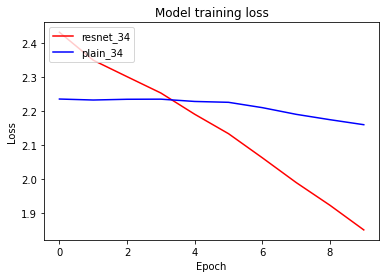

In [27]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

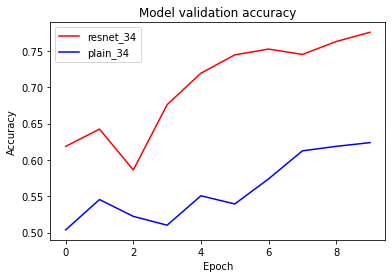

In [28]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

### ResNet50 vs Plain50

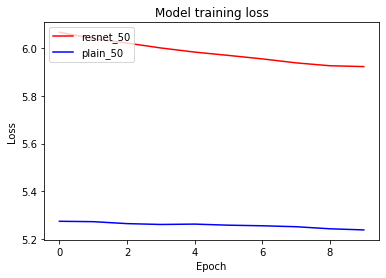

In [32]:
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

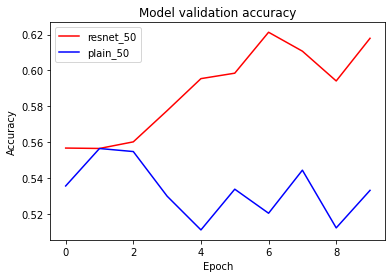

In [33]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

---

## 6. 정리

### (1) 결과

#### resnet34 vs plain34
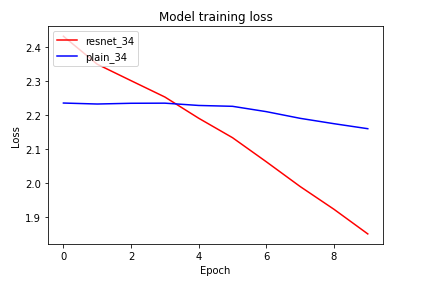
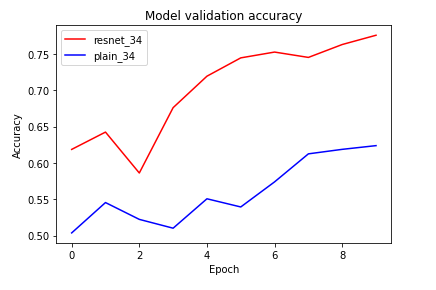
- training loss가 resnet34가 급격하게 감소하고 있는걸 볼 수 있다
- accuracy가 resnet34가 훨씬 높은 걸 볼 수 있다

#### resnet50 vs plain50
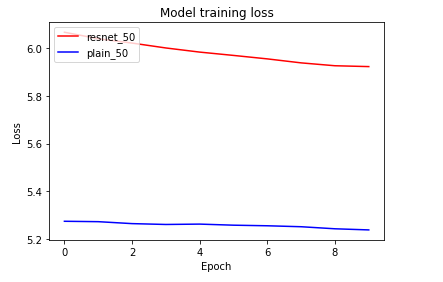
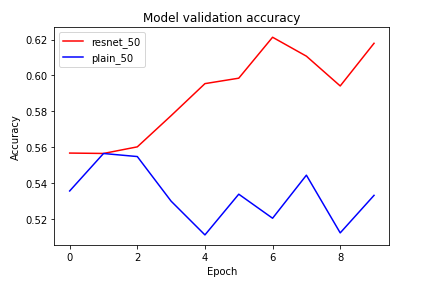
- 레이어가 더 많아서.. 에폭을 더 늘려야 하는건지.. loss는 plain50이 훨씬 낮고 resnet50이 감소하는 추세인것 같긴 한데 10에폭밖에 돌리지 않아서 loss는 더 돌려봐야 알 것 같다
- accuracy는 resnet50이 훨씬 높은 걸 볼 수 있다


### (2) 과정
- VGG 모델을 구현하는걸 바탕으로 ResNet을 구현해보려 했는데 정말 너무 힘들었다. ResNet 그림을 보고 금방 할 수 있을 줄 알았는데 생각보다 까다로웠다.. 정말 많은 시행착오를 겪었고... 구글의 도움을 많이 받았다.. 
- 모델을 구현하고도 많은 에러를 많나서 정말 울뻔했다. input shape을 잘못 넣고서는 여기저기서 헤맸고 데이터의 class 수도 잘못 써서 여기저기서 정말 힘들었었다.
- 그리고 처음엔 epoch 20으로 시작했었는데 4번정도 kernel이 죽어서 이것저것 수정해서 해보고 결국.. epoch을 15로 줄여봤는데.. 또 kernel이 죽어서.. 10으로 줄여서 2번만에 성공했다..! 
- 그리고 모델을 돌리면서 `corrupt jpeg data: 99 extraneous bytes before marker 0xd9`이 경고를 해치우고 싶었는데 불가능했다. 같은 조 지훈님도 같은 경고를 만나서 코랩에서 다시 해봤는데 그땐 저 경고가 뜨지 않았다 한다. 왜 그럴까...?
- 아래는 내가 참고한 사이트들이다
    - https://hwanny-yy.tistory.com/12
    - https://ichi.pro/ko/tensorflow-2-0eulo-resnet-50-ihae-mich-guhyeon-19313288619665
    - https://mypark.tistory.com/entry/Tensorflow-2Keras-Week-4-Implementing-ResNet
    
### (3) 회고
- 그래도 이 프로젝트를 통해서 Resnet하나는 질리도록 본 것 같다. 다 만들어져있는 모델이지만 이렇게 구현을 해보니까 더 잘 알게되는 것 같다. 
- 이번 프로젝트를 하면서 정말 다양한 많은 에러를 만났는데... 이제 놀랍지도 않다. 누가 그랬다. 에러를 만나면 반기라고.... 난 열심히 반기는 중이다.. ^^
- 그동안 배운 내용들을 다시 한번 복습해봐야 할 것 같다
- 제출하려고 하니... 행복하다 :)